<a href="https://colab.research.google.com/github/MiguelAguilera/Neuro-MaxEnt-inference-tutorial/blob/main/3.Network_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maximum Entropy for network dynamics

## 1. Introduction

In some cases, we are not interested in the stationary distribution generating some data, but in the statistical properties of its transient dynamics. Similar to the Maximum Entropy principle is the Maximum Caliber principle (MaxCal), which applies the idea of maximum entropy models to trajectories or paths.

$$ S_{0:t} =- \sum_{\mathbf x_{0:t}} p(\mathbf x_{0:t}) \log p(\mathbf x_{0:t}).$$

with $\mathbf x_{0:t} =\{\mathbf x_0, \mathbf x_1, \ldots, \mathbf x_t\}$.

Generally, if we are interested in causal models, we add a temporal consitencty requirement (Kolmogoroff, 2013), imposing that
$$ \sum_{\mathbf x_{t+1}} p^{(t+1)}(\mathbf x_{0:t+1})= p^{(t)}(\mathbf x_{0:t}).$$

That is, knowledge of the future should not affect our models of the past.

This yields a dynamical rule for describing trajectories. For example, in the case of assuming Markovian (i.e. memoryless) processes, we have that 

$$ p(\mathbf x_{0:t} ) \propto  p(\mathbf x_{0}) \prod_{u=1}^t \exp\left(\sum_n \lambda_n f_n(\mathbf x_{u},\mathbf x_{u-1}) \right). $$

## 2. Learning oscillatory spike trains

Several models assume that the combination of recurrent networks of inhibitory and exciatory cells alone can explain the generation and main characteristics of oscillatory neural activity.

> ![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41586-022-05293-w/MediaObjects/41586_2022_5293_Fig2_HTML.png?as=webp)
> Oscillating activity in recurrent network with excitatory (blue) and inhibitory (red) neurons. Figure from Lindén, H., Petersen, P. C., Vestergaard, M., & Berg, R. W. (2022). Movement is governed by rotational neural dynamics in spinal motor networks. _Nature_, 610(7932), 526-531.

#### The kinetic Ising model

We assume the Glauber rule, with one spin update per discrete time step

$$ p^\mathrm{flip}_i(\mathbf{x}) = \frac{\exp\left( - \beta x_i h_i \right)}{2\cosh\left( \beta h_i \right)}$$ $$ h_i =  H_i + \sum_{j\neq i} J_{ij}x_j$$

This is equivalent to 
$$ p(x_{i,t}|\mathbf{x}_{t-1}) = \frac{\exp\left( - \beta x_{i,t}h_{i,t} \right)}{2\cosh\left( \beta h_{i,t} \right)}$$ $$ h_{i,t} =  H_i + \sum_{j\neq i} J_{ij}x_{j,t-1}$$

In this case, the maximum likelihood learning rule (Zeng _et al_, 2013) is


$$H_i \leftarrow  H_i + \eta( \langle x_{i,t} \rangle_\mathrm{data}^\mathrm{flip}  -  \langle x_{i,t}\rangle_\mathrm{model}^\mathrm{flip}  )$$ 

$$  J_{ij}\leftarrow   J_{ij} + \eta(\langle x_{i,t} x_{j,t-1} \rangle_\mathrm{data}^\mathrm{flip}   -  \langle x_{i,t} x_{j,t-1} \rangle_\mathrm{model}^\mathrm{flip}  )$$ 



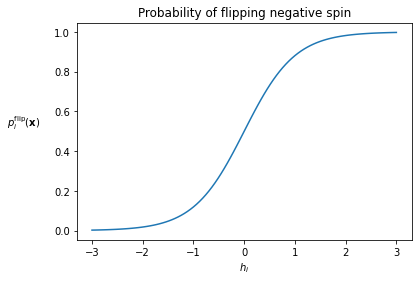

In [ ]:
h=np.linspace(-3,3,100)
p=np.exp(h)/2/np.cosh(h)

plt.figure()
plt.plot(h,p)
plt.title('Probability of flipping negative spin')
plt.ylabel(r'$p^\mathrm{flip}_i(\mathbf{x}) $',rotation=0,labelpad=30)
plt.xlabel(r'$h_i$');

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Define model
class Ising:
    def __init__(self, netsize):    #Create ising model
    
        self.size=netsize
        self.H=np.zeros(netsize)
        self.J=np.zeros((netsize,netsize))
        self.randomize_state()
        self.beta=1.0
    
    def randomize_state(self):
        self.s = np.random.randint(0,2,self.size)*2-1

    def SequentialMetropolisStep(self):
        for i in np.random.permutation(self.size):
            self.MetropolisStep(i)
  
    def GlauberStep(self,i=None):            # Execute step of the Glauber algorithm
        if i is None:
            i = np.random.randint(self.size)
        h = self.H[i] + np.dot(self.J[i,:],self.s)
        self.s[i] = int(np.random.rand()*2-1 < np.tanh(self.beta*h))*2-1   # Glauber

    def SequentialGlauberStep(self):        # Execute N steps of the Glauber algorithm
        for i in np.random.permutation(self.size):
            self.GlauberStep(i)
  
    def SequentialGlauberStepT0(self,i=None):            # Sequential Glauber step at zero temperature
        for i in np.random.permutation(self.size):
          h = self.H[i] + np.dot(self.J[i,:],self.s)
          self.s[i] = np.sign(h) 


### 2.1 Generating reference data distribution

We generate a sample of spiking neuron data using a network with a random configuration. We store the relevant statistics in `m_data ` and  `Cov_data `.


Text(0.5, 1.0, 'Neuronal Spike Times')

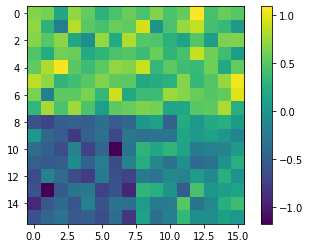

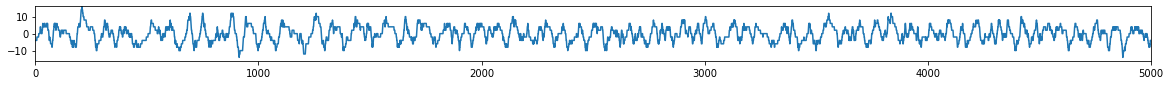

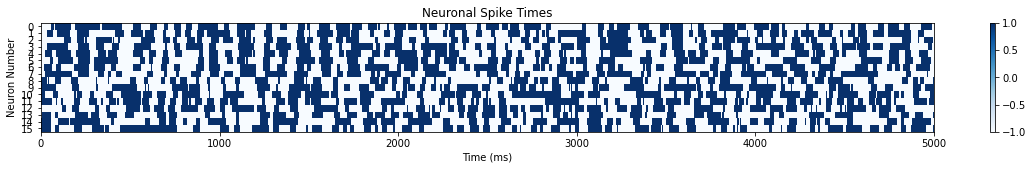

In [ ]:
N=16
T=5000

I_data = Ising(N)
I_data.H = 0.05*np.random.randn(N)
I_data.J = np.random.randn(N,N)/np.sqrt(N)
I_data.J[0:N//2,0:N//2] += 8/N
I_data.J[0:N//2,N//2:] += 8/N
I_data.J[N//2:,0:N//2,] += -8/N

plt.figure()
plt.imshow(I_data.J)
plt.colorbar()

Data_sample = np.zeros((N,T))

m_data=np.zeros(N)

C_data=np.zeros((N,N))
D_data=np.zeros((N,N))

I_data.randomize_state()
I_data.s = np.ones(N)
for t in range(T):
  I_data.SequentialGlauberStep()
for t in range(T):
  sp = I_data.s.copy()
  I_data.GlauberStep()
  Data_sample[:,t] = I_data.s
  m_data += I_data.s/T
  D_data  += np.einsum('i,j->ij',I_data.s/T, sp)
  C_data += np.einsum('i,j->ij',sp/T, sp)

m_data = np.mean(Data_sample,axis=1)
Cov_data  = np.cov(Data_sample)

fig, ax = plt.subplots(figsize=(20,1))
plt.plot(np.sum(Data_sample,axis=0))
plt.axis([0,T,-N,N])


fig, ax = plt.subplots(figsize=(20,2))
plt.imshow(Data_sample, aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar()

ax.set_xlim([0, T])
ax.set_xlabel('Time (ms)')
# specify tick marks and label label y axis
ax.set_yticks(range(N))
ax.set_ylabel('Neuron Number')
ax.set_title('Neuronal Spike Times') 

### 2.2 Learning a MaxEnt model

Given the statistics from the data generated by the reference model, MaxEnt learnign adjusts the means and covariances of the model.

Text(0.5, 0, 'epoch')

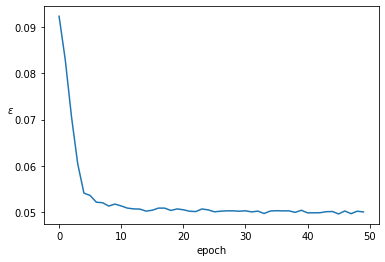

In [ ]:
I = Ising(N)
I.H = np.zeros(N)
I.J = np.zeros((N,N))

R=50
eta=0.1

error = np.zeros(R)

for rep in range(R):

  MaxEnt_sample = np.zeros((N,T))
  m=np.zeros(N)
  C=np.zeros((N,N))
  D=np.zeros((N,N))
  I.s = Data_sample[:,0]

  dm = np.zeros(N)
  dJ = np.zeros((N,N))
  for t in range(T):
    h = I.H + np.dot(I.J,I.s)
    sp = I.s.copy()
    I.SequentialGlauberStep()
    dm += (I.s*N - sp*(N-1) - np.tanh(h))/T
    dJ += (D_data*N - (N-1)*C_data)/T - np.einsum('i,j->ij',(np.tanh(h))/T, sp)
    MaxEnt_sample[:,t] = I.s
    m += I.s/T
    D += np.einsum('i,j->ij',I.s/T, sp)
    C += np.einsum('i,j->ij',sp/T, sp)
    
  m = np.mean(MaxEnt_sample,axis=1)
  Cov  = np.cov(MaxEnt_sample)

  I.H += eta*(m_data-m)
  I.J += eta*(Cov_data - Cov)
  I.J[range(N),range(N)]=0 

  error[rep] = np.mean(dJ**2)
  #error[rep] = np.mean((m_data-m)**2)

plt.figure()
plt.plot(error)
plt.ylabel(r'$\epsilon$',rotation=0)
plt.xlabel(r'epoch')


#### Comparison of the original and inferred model

Here we show data, statistics and parameters of the original and inferred models

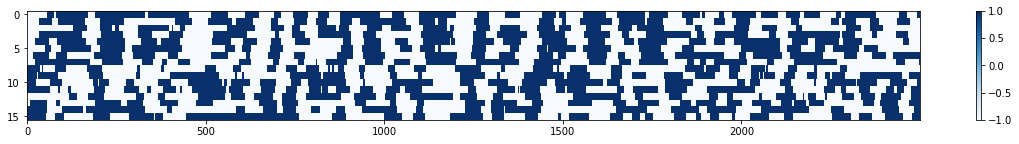

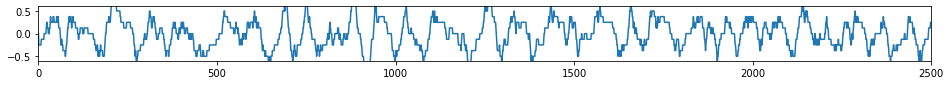

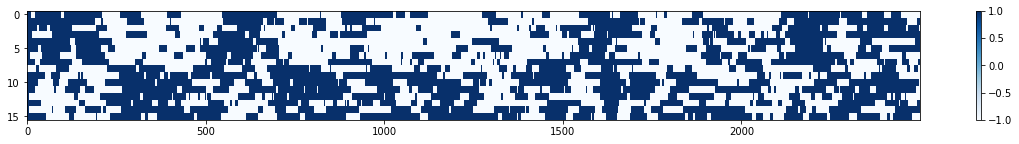

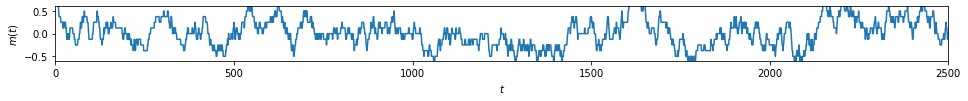

In [ ]:
  MaxEnt_sample = np.zeros((N,T))
  I.s = Data_sample[:,0]
  for t in range(T):
    I.GlauberStep()
    MaxEnt_sample[:,t] = I.s

S_data = np.mean(Data_sample[:,0:T//2], axis=0)
S_model = np.mean(MaxEnt_sample[:,0:T//2], axis=0)
plt.figure(figsize=(20,2))
plt.imshow(Data_sample[:,0:T//2], aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar()
plt.figure(figsize=(16,1))
plt.plot(S_data)
plt.axis([0,T//2,-0.6,0.6])

plt.figure(figsize=(20,2))
plt.imshow(MaxEnt_sample[:,0:T//2], aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar()
plt.figure(figsize=(16,1))
plt.plot(S_model)
plt.axis([0,T//2,-0.6,0.6])
plt.xlabel(r'$t$')
plt.ylabel(r'$m(t)$');

#### Compare covariance matrices

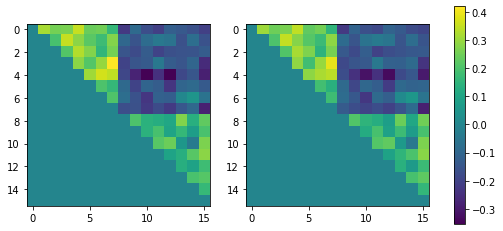

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(9,4))
im = ax[0].imshow(np.triu(C_data,1),cmap='viridis',vmin=min(np.min(np.triu(C_data,1)),np.min(np.triu(C,1))), vmax=max(np.max(np.triu(C_data,1)),np.max(np.triu(C,1))))
im = ax[1].imshow(np.triu(C,1), cmap='viridis',vmin=min(np.min(np.triu(C_data,1)),np.min(np.triu(C,1))), vmax=max(np.max(np.triu(C_data,1)),np.max(np.triu(C,1))))
fig.colorbar(im, ax=ax.ravel().tolist())

#### Compare spike-count temporal correlations

From the distribution above, we can calculate the probability of the system of showing $X$ simultaneous spikes

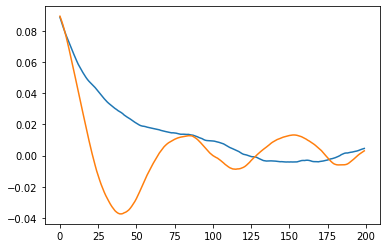

In [ ]:
lags = np.arange(200)
L=len(lags)
Dlag_data = np.zeros(L)
Dlag = np.zeros(L)

Dlag_data[0]=np.var(S_data)
Dlag[0]=np.var(S_model)
for i,lag in enumerate(lags[1:]):
  Dlag_data[i+1] = np.cov(S_data[lag:],S_data[0:-lag])[0,1]
  Dlag[i+1] = np.cov(S_model[lag:],S_model[0:-lag])[0,1]
plt.plot(lags,Dlag)
plt.plot(lags,Dlag_data);


### 2.2 Learn a MaxCal model

For learning the MaxCal model, we need to compare the covariances between spins over spin updates.

Text(0.5, 0, 'epoch')

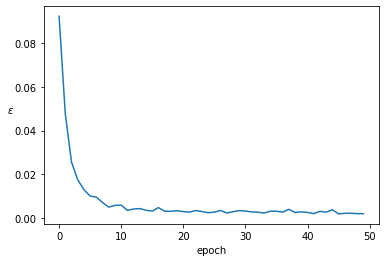

In [ ]:
I = Ising(N)
I.H = np.zeros(N)
I.J = np.zeros((N,N))

R=50
eta=0.2

error = np.zeros(R)

for rep in range(R):

  MaxCal_sample = np.zeros((N,T))
  m=np.zeros(N)
  C=np.zeros((N,N))
  D=np.zeros((N,N))
  I.s = Data_sample[:,0]

  dm = np.zeros(N)
  dJ = np.zeros((N,N))
  for t in range(T):
    h = I.H + np.dot(I.J,I.s)
    sp = I.s.copy()
    I.GlauberStep()
    dm += (I.s*N - sp*(N-1) - np.tanh(h))/T
    dJ += (D_data*N - (N-1)*C_data)/T - np.einsum('i,j->ij',(np.tanh(h))/T, sp)
    MaxCal_sample[:,t] = I.s
    m += I.s/T
    D += np.einsum('i,j->ij',I.s/T, sp)
    C += np.einsum('i,j->ij',sp/T, sp)
    
  m = np.mean(MaxCal_sample,axis=1)
  Cov  = np.cov(MaxCal_sample)

  I.H += eta*dm
  I.J += eta*dJ

  error[rep] = np.mean(dJ**2)
  #error[rep] = np.mean((m_data-m)**2)

plt.figure()
plt.plot(error)
plt.ylabel(r'$\epsilon$',rotation=0)
plt.xlabel(r'epoch')


### Comparison of the original and inferred model

Here we show data, statistics and parameters of the original and inferred models

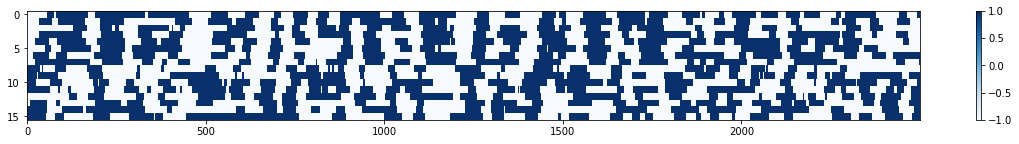

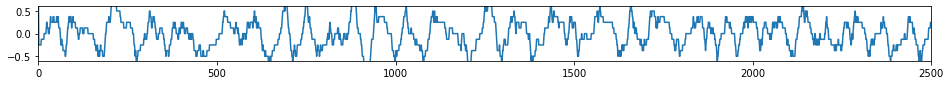

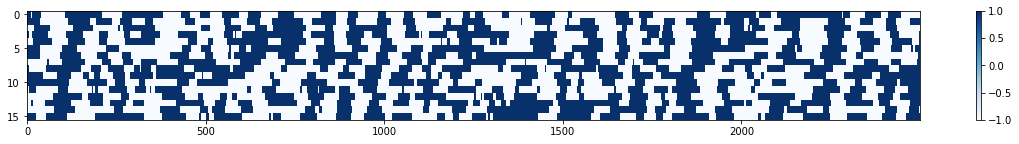

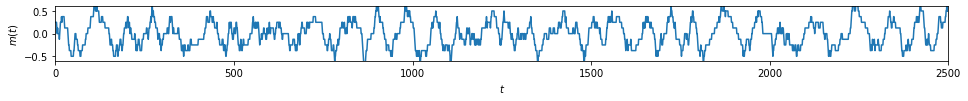

In [ ]:
S_data = np.mean(Data_sample[:,0:T//2], axis=0)
S_model = np.mean(MaxCal_sample[:,0:T//2], axis=0)
plt.figure(figsize=(20,2))
plt.imshow(Data_sample[:,0:T//2], aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar()
plt.figure(figsize=(16,1))
plt.plot(S_data)
plt.axis([0,T//2,-0.6,0.6])

plt.figure(figsize=(20,2))
plt.imshow(MaxCal_sample[:,0:T//2], aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar()
plt.figure(figsize=(16,1))
plt.plot(S_model)
plt.axis([0,T//2,-0.6,0.6])
plt.xlabel(r'$t$')
plt.ylabel(r'$m(t)$');

#### Compare spike-count temporal correlations

From the distribution above, we can calculate the probability of the system of showing $X$ simultaneous spikes

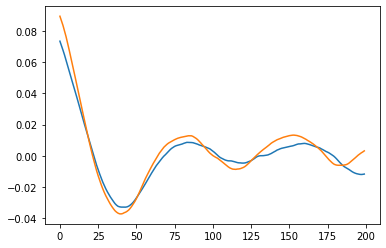

In [ ]:
lags = np.arange(200)
L=len(lags)
D_data = np.zeros(L)
D = np.zeros(L)

D_data[0]=np.var(S_data)
D[0]=np.var(S_model)
for i,lag in enumerate(lags[1:]):
  D_data[i+1] = np.cov(S_data[lag:],S_data[0:-lag])[0,1]
  D[i+1] = np.cov(S_model[lag:],S_model[0:-lag])[0,1]
plt.plot(lags,D)
plt.plot(lags,D_data);


#### Compare weight matrices

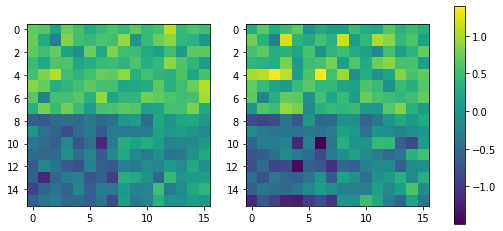

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(9,4))
im = ax[0].imshow(I_data.J, cmap='viridis',vmin=min(np.min(I_data.J),np.min(I.J)), vmax=max(np.max(I_data.J),np.max(I.J)))
im = ax[1].imshow(I.J, cmap='viridis',vmin=min(np.min(I_data.J),np.min(I.J)), vmax=max(np.max(I_data.J),np.max(I.J)))
fig.colorbar(im, ax=ax.ravel().tolist());

#### Compare covariance matrices

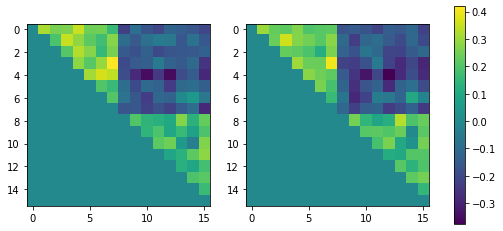

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(9,4))
im = ax[0].imshow(np.triu(C_data,1),cmap='viridis',vmin=min(np.min(np.triu(C_data,1)),np.min(np.triu(C,1))), vmax=max(np.max(np.triu(C_data,1)),np.max(np.triu(C,1))))
im = ax[1].imshow(np.triu(C,1), cmap='viridis',vmin=min(np.min(np.triu(C_data,1)),np.min(np.triu(C,1))), vmax=max(np.max(np.triu(C_data,1)),np.max(np.triu(C,1))))
fig.colorbar(im, ax=ax.ravel().tolist())

Coupling matrices

## 3. References

Zeng, H. L., Alava, M., Aurell, E., Hertz, J., & Roudi, Y. (2013). Maximum likelihood reconstruction for Ising models with asynchronous updates. Physical review letters, 110(21), 210601.